# Predictive Models
## Modern Timeseries analysis

### Hidden Markov Model


In [ ]:
!pip install hmmlearn # Niet runnen met eigen pc als host ==> conda runnen
!pip install requests

     |████████████████████████████████| 378kB 5.8MB/s 


In [ ]:
import pandas as pd
import scipy as sp
import numpy as np
import requests
from hmmlearn import hmm
from hmmlearn.hmm import GaussianHMM
import json
from datetime import datetime
import asyncio
import time
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from matplotlib.pyplot import figure
sns.set(font_scale=1.5)

## Getting data from IRCEL API

*Javascript om datarange op te halen*

TimeSeriesController.getMaxTimeExtent()
returns:

Object { from: {…}, till: {…} }
​
from: Object { _isAMomentObject: true, _i: 1390957200000, _isUTC: false, … }
​​
_d: Date Wed Jan 29 2014 02:00:00 GMT+0100 (Central European Standard Time)
​​
_i: **1390957200000**
​​
_isAMomentObject: true
​​
_isUTC: false
​​
_locale: Object { _ordinalParse: /\d{1,2}(th|st|nd|rd)/, ordinal: ordinal(number)
, _abbr: "en", … }
​​
_pf: Object { empty: false, overflow: -2, charsLeftOver: 0, … }
​​
<prototype>: Object { clone: clone(), valueOf: valueOf(), unix: unix()
, … }
​
till: Object { _isAMomentObject: true, _i: **1617019200000**, _isUTC: false, … }
​
<prototype>: Object { … }

In [ ]:
def getAPIData(url:str) -> list:
  try:
    res =  requests.get(url)
    assert res.status_code==200
  except:
    raise AssertionError("Fout in data ophalen")
  data =json.loads(res.content).get("10703",None).get("values")
  return data

def getyeardata(year:int) -> list:
  """
  Api has a maximum period lenght of <1 year. Full year data is collected in two api calls

  """
 
  url1 =f"https://geo.irceline.be/sos/api/v1/timeseries/10703/getData?timespan={year-1}-12-31T23%3A00%3A00%2B01%3A00%2F{year}-08-01T00%3A55%3A00%2B02%3A00&generalize=false&expanded=true&format=flot&locale=en"
  a=  getAPIData(url1)
  yeardata = a
  print("length a:", len(a))

  url2 =f"https://geo.irceline.be/sos/api/v1/timeseries/10703/getData?timespan={year}-07-31T23%3A00%3A00%2B02%3A00%2F{year+1}-01-01T00%3A55%3A00%2B01%3A00&generalize=false&expanded=true&format=flot&locale=en"
  b= getAPIData(url2)
  print("length b:",len(b))
  yeardata.extend(b)
  # print("data a:\n",a,"\ndata b:\n",b)
  return yeardata

In [ ]:
startpoint = pd.to_datetime(1390957200000,unit="ms")#29-01-2014
endpoint= pd.to_datetime(1617019200000,unit="ms")#29-03-2021
print("Data available between:", startpoint," and ",endpoint)

data = []
# start is 2014!
for year in range(2017,2020):
  print("Getting data for: ", year)
  data.extend(getyeardata(year))

df = pd.DataFrame(data=[(x,y) for x,y in data],columns=["timestamp","no2"])
df["date"]= pd.to_datetime(df.timestamp,unit="ms") 
df=df.set_index('date')
df.drop("timestamp",inplace=True,axis=1)
df.dropna(inplace= True)
raw_api_data = df


Data available between: 2014-01-29 01:00:00  and  2021-03-29 12:00:00
Getting data for:  2017
length a: 5089
length b: 3675
Getting data for:  2018
length a: 5089
length b: 3675
Getting data for:  2019
length a: 5089
length b: 3675


[linktekst](https://)ruwe api data zit in raw_api_data:

* Waarden in µg/m3
*   Moet mogelijks nog gecleand worden
*   Keuze tussen droppen of vullen nan. Geen idee wat best is voor hmm



In [ ]:
raw_api_data.to_csv("no2.csv")

# Weather data Basel

In [ ]:
data = pd.read_csv("/content/data/dataexport_20210413T084601.csv", header= 9)
temp= data["Bazel Temperature [2 m elevation corrected]"]


FileNotFoundError: ignored

## Data viz
**Deal with NaN's**

In [ ]:

raw_api_data = raw_api_data.astype('float64')
raw_api_data= raw_api_data.interpolate(method= "time")
NO2 = raw_api_data

**Short Time period**

168


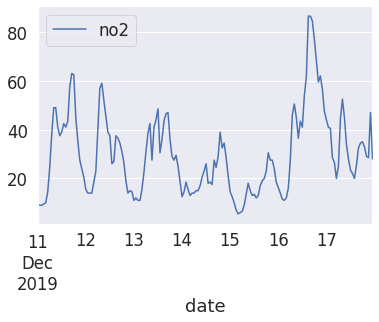

In [ ]:
selection = raw_api_data[(raw_api_data.index < datetime(2019,12,18))
& (raw_api_data.index >= datetime(2019,12,11))]
print(len(selection))
selection.plot()


**Long Time, resampled**

Text(0, 0.5, '$NO_2$')

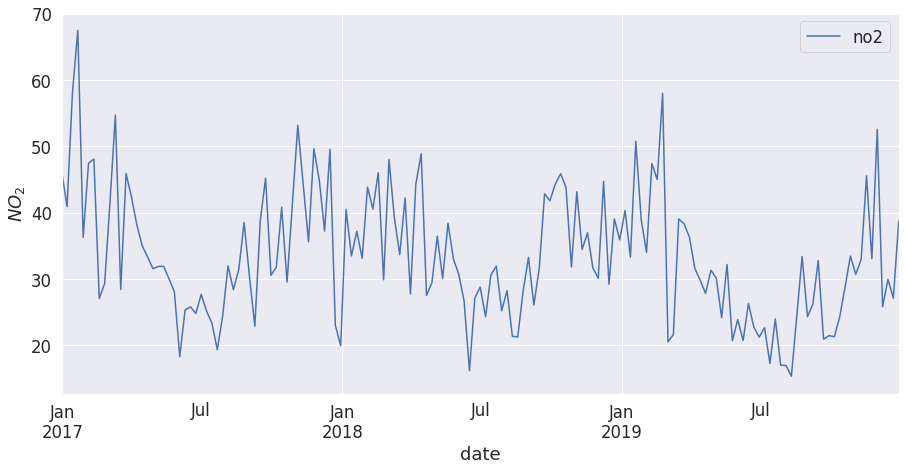

In [ ]:
# axis=clean_data = clean_data.astype("int32")
fix,ax = plt.subplots(1,1,figsize=[15,7])
resampled_data = raw_api_data.resample('7D').mean()
resampled_data.plot(ax=ax)
ax.set_ylabel('$NO_2$')

# Getting Vinder DATA
Vlinder zijn weerstations voor citizenscience: 
https://www.meteo.be/services/wow/viewStation.php?id=561e78bd-9f85-e711-9402-0003ff59767d&lang=nl

Is een proefproject van onder meer de UGent

## Ophalen data weerstation Sterre
- Api laat maar records per maand toe: Net zoals voor IRCEL iteratief ophalen en samenvoegen

=> er moeten wat cookies meegestuurd worden, slaat daarom op in een .csv zodat we dit slechts 1 malig moeten doen.

In [ ]:
def getAPIData(url:str) -> list:
  try:
    res =  requests.get(url)
    assert res.status_code==200
  except:
    print(res.status_code)
    print(res.__dict__)
    raise AssertionError("Fout in data ophalen")
  data =json.loads(res.content)
  return data

def getMonthData(month:int) -> list:
  # url = f"https://www.meteo.be/services/wow/ajax/getGraphData.php?id=41a7d947-7275-e911-80e7-0003ff59889d&start=2020-{month}-01T10%3A50%3A00.000Z&end=2020-{month+1}-01T10%3A59%3A59.000Z"
  if month != 12:
    url =f"https://www.meteo.be/services/wow/ajax/getGraphData.php?id=561e78bd-9f85-e711-9402-0003ff59767d&start=2018-{month}-01T12%3A20%3A00.000Z&end=2018-{month+1}-01T12%3A29%3A59.000Z"
  else:
    url =f"https://www.meteo.be/services/wow/ajax/getGraphData.php?id=561e78bd-9f85-e711-9402-0003ff59767d&start=2018-{month}-01T12%3A20%3A00.000Z&end=2019-{1}-01T12%3A29%3A59.000Z"
 
  tries = 0
  while tries <= 3:
    try:
      print("Getting month ", month)
      data = getAPIData(url)
      
    except AssertionError:
      print("Failed to get data, retrying")
      tries +=1
      continue

    return data
  
dataset = []

for i in range(13):
  
  a = getMonthData(i)
  data = [(x.get("timestamp"), 
           x.get("primary").get("dt"),
           x.get("primary").get("dws"), 
           x.get('primary').get('dwd'),
           x.get('primary').get('drr'),
           x.get('primary').get("dm"),
           x.get('primary').get("dh")
           ) for x in a]

  dataset.extend(data)

Getting month  0
Getting month  1
Getting month  2
Getting month  3
504
{'_content': b'<!DOCTYPE HTML PUBLIC "-//IETF//DTD HTML 2.0//EN">\n<html><head>\n<title>504 Gateway Timeout</title>\n</head><body>\n<h1>Gateway Timeout</h1>\n<p>The gateway did not receive a timely response\nfrom the upstream server or application.</p>\n</body></html>\n', '_content_consumed': True, '_next': None, 'status_code': 504, 'headers': {'Date': 'Tue, 13 Apr 2021 11:42:55 GMT', 'Server': 'Apache', 'Content-Length': '247', 'Keep-Alive': 'timeout=5, max=100', 'Connection': 'Keep-Alive', 'Content-Type': 'text/html; charset=iso-8859-1'}, 'raw': <urllib3.response.HTTPResponse object at 0x7fe701510050>, 'url': 'https://www.meteo.be/services/wow/ajax/getGraphData.php?id=561e78bd-9f85-e711-9402-0003ff59767d&start=2018-3-01T12%3A20%3A00.000Z&end=2018-4-01T12%3A29%3A59.000Z', 'encoding': 'iso-8859-1', 'history': [], 'reason': 'Gateway Timeout', 'cookies': <RequestsCookieJar[]>, 'elapsed': datetime.timedelta(seconds=10

787.99


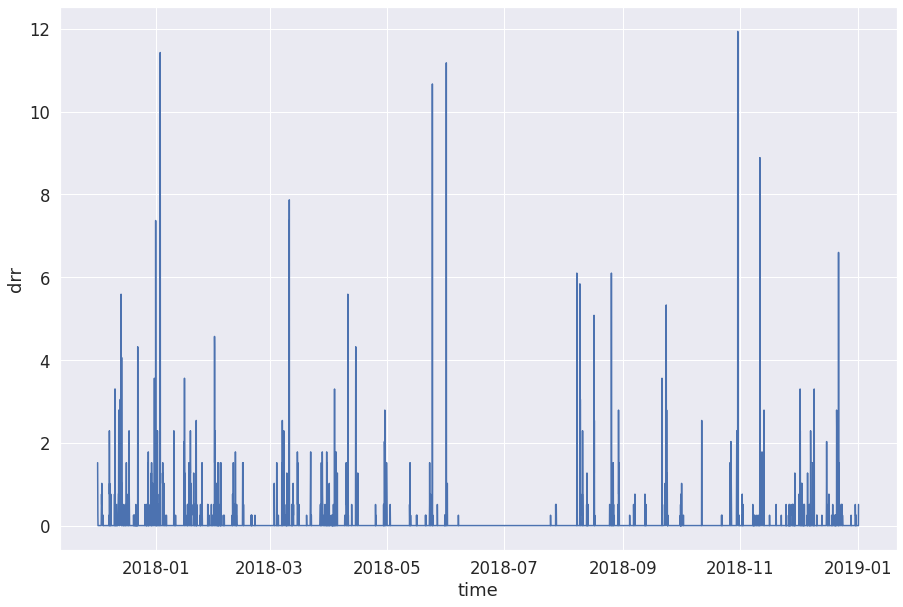

In [ ]:
weerdata = pd.DataFrame(data=dataset,columns=["timestamp","dt","dws","dwd","drr","dm","dh"])
time = pd.to_datetime(weerdata.timestamp,format="%Y-%m-%dT%H:%M")
weerdata['time'] = time
weerdata = weerdata.set_index('time')
# somehow timezone aware
weerdata.index = weerdata.index.tz_localize(None)

fig, ax =plt.subplots(1,1,figsize=[15,10])
sns.lineplot(x=weerdata.index,y=weerdata['drr'],ax=ax)
print(weerdata.drr.sum())

# combine weather and NO2 data

Following var are included in weather data
*   Temperature
*   Precipitation
*   Wind
*   Pressure
*   Relative Humidity

Could be added:
*   Radiation




*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


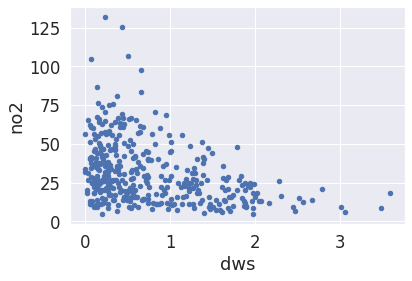

In [ ]:
weerdata = weerdata.resample('D').mean()
complete_data = weerdata.join(NO2).dropna()
complete_data.plot.scatter(x="dws",y="no2")
complete_data.head()
complete_data.to_csv("./weerdata/weer_no2.csv")

#Inlezen data van hierboven

In [ ]:
data = pd.read_csv("./weerdata/weer_no2.csv")
data['time'] = data['Unnamed: 0']
data = data.set_index('time')
data = data.drop("Unnamed: 0",axis=1)
data.head(10)

,dt,dws,dwd,drr,dm,dh,no2
time,,,,,,,
2017-12-01,0.150000,0.036364,228.636364,0.253333,1022.454545,95.833333,65.5
2017-12-02,-1.604167,0.433043,195.913043,0.000000,1027.826087,96.958333,125.5
2017-12-03,1.479167,0.680000,225.083333,0.275000,1026.975000,97.291667,43.5
2017-12-04,5.395833,0.277917,234.875000,0.052083,1033.020833,96.666667,57.0
2017-12-05,6.708333,0.819130,230.608696,0.000000,1035.934783,87.166667,50.0
2017-12-06,7.350000,1.186667,218.458333,0.000000,1030.866667,86.083333,27.5
2017-12-07,5.300000,1.841304,213.130435,0.254167,1014.126087,90.291667,23.5
2017-12-08,2.779167,0.890833,245.041667,0.063333,1013.254167,84.916667,29.0
2017-12-09,1.533333,1.390417,229.625000,0.000000,1014.350000,86.541667,37.5


# Hidden Markov Models (hmm)


In [ ]:
def fitHMM(vals, n_states):
    vals = np.reshape(vals,[len(vals),1])
    
    # fit Gaussian HMM to Q
    model = GaussianHMM(n_components=n_states, n_iter=100).fit(vals)
     
    # classify each observation as state 0 or 1
    hidden_states = model.predict(vals)
 
    # fit HMM parameters
    mus = np.squeeze(model.means_)
    sigmas = np.squeeze(np.sqrt(model.covars_))
    transmat = np.array(model.transmat_)
    print(mus)
    print(sigmas)
    # re-order parameters in ascending order of mean of underlying distribution
    idx      = np.argsort(mus)
    mus      = mus[idx]
    sigmas   = sigmas[idx]
    transmat = transmat[idx, :][:, idx]
    
    state_dict = {}
    states = [i for i in range(n_states)]
    for i in idx:
        state_dict[i] = states[idx[i]]
    
    relabeled_states = [state_dict[h] for h in hidden_states]
    return (relabeled_states, mus, sigmas, transmat, model)

In [ ]:
#rows = raw_api_data.tail(1500)
#print(rows)
hidden_states, mus, sigmas, transmat, model = fitHMM(temp.values, 3)

[14.72731458  2.85748976]
[4.74307846 2.50975152]


In [ ]:
def plot_states(ts_vals, states, time_vals):
    
    fig, ax1 = plt.subplots(1,1,figsize=[25,7], dpi= 80)
    

    color = 'tab:red'
    ax1.set_xlabel('Date')
    ax1.set_ylabel('$\mu$g/$m^3$',         color=color)
    ax1.plot(time_vals, ts_vals,      color=color)
    ax1.tick_params(axis='y',            labelcolor=color)

    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Hidden state', color=color)  
    ax2.plot(time_vals,states,     color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  
    plt.show()

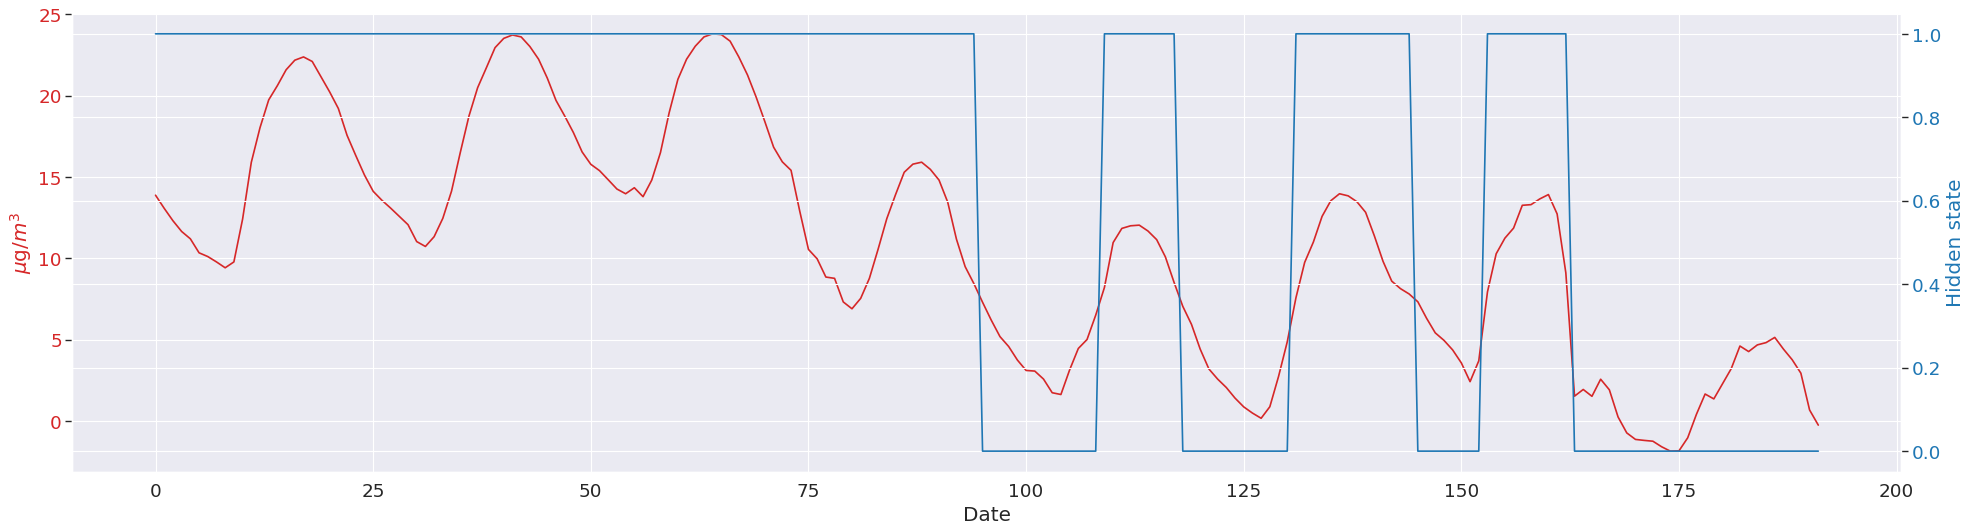

In [ ]:
plot_states(temp.values, hidden_states, temp.index)